<h1 class="title">A sequential Bayesian model for <br /><em>learning</em> and <em>memory</em> in <br /><em>multi-context</em> environments</h1>

<p class="author">
Dave F. Kleinchmidt
<span class="affiliation">Rutgers University/Princeton Neuroscience Institute</span>
<br />
Pernille Hemmer
<span class="affiliation">Rutgers University</span>
</p>
<p class="venue">24 July 2018 // MathPsych // <a href="https://osf.io/dqz73/">osf.io/dqz73</a></p>

<script type="text/javascript">

$(document).ready(function(){
    setTimeout(function() {
        Reveal.configure({
            transition: 'none',
            center: false
        });
        console.log("Configured!");
    }, 3000);
});
</script>

In [622]:
using 
    Plots,
    PlotThemes,
    StatPlots,
    RecipesBase,
    Colors, 
    Images,
    DataFrames,
    DataFramesMeta,
    Underscore,
    ConjugatePriors,
    Particles,
    Distances, 
    JuliennedArrays

theme(:default, markerstrokecolor=:white)

flip(x::AbstractVector) = reshape(x, (1,:))

const It = Base.Iterators

using Revise
Revise.track("modeling.jl")
using DotLearning
include("experiments.jl")
include("plots.jl")

using JLD2
@load "data/dots2014.jld2"
@load "prior_empirical.jld2"
@load "results/run3-2018-07-18T12:40:07.059.jld2" results expts

rho(args...) = sqrt(sum(args.^2))

rho (generic function with 1 method)

<div class="intro">

<p>in the real world judgements are made in</p>
<p class="big">context</p>
<p class="fragment">which provides <em>useful information</em></p>
</div>

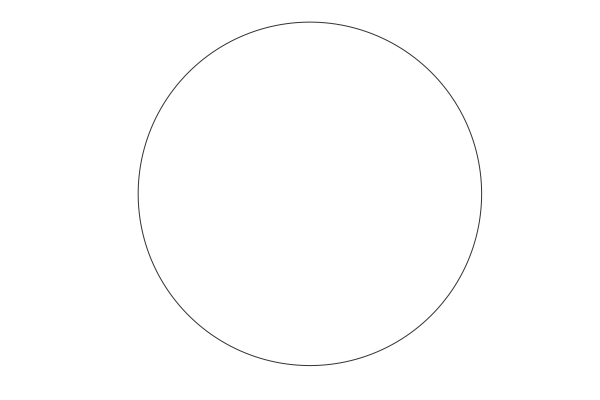

In [623]:
arena()

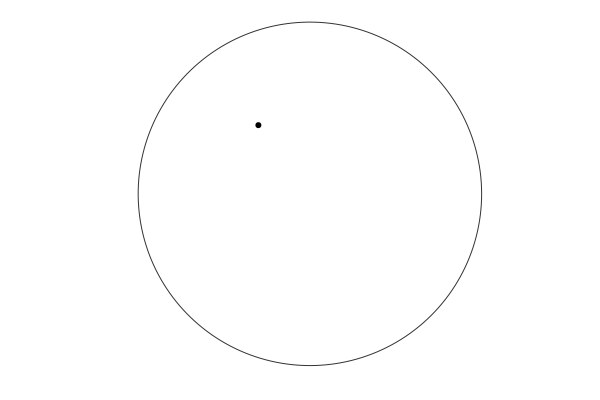

In [624]:
x, y = -0.3, 0.4
arena([x], [y], color="black")

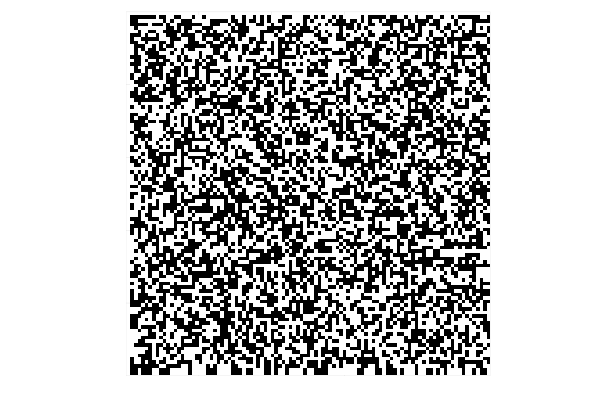

In [625]:
plot(Gray.(rand(Bool, 100,100)), axis=false, lims=(0,100), aspect_ratio=:equal)

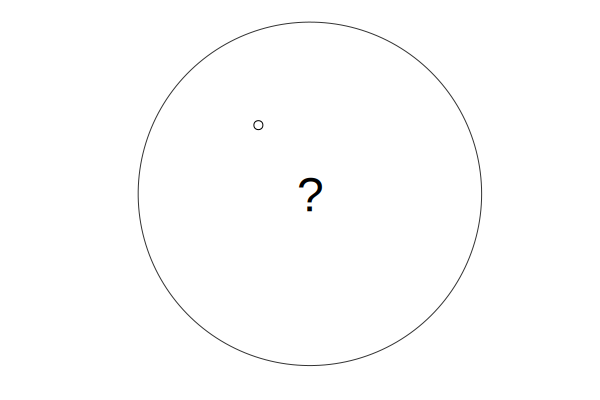

In [626]:
arena([x], [y], color=:white, markerstrokecolor=:black, markersize=5)
annotate!(0,0, text("?", 32))

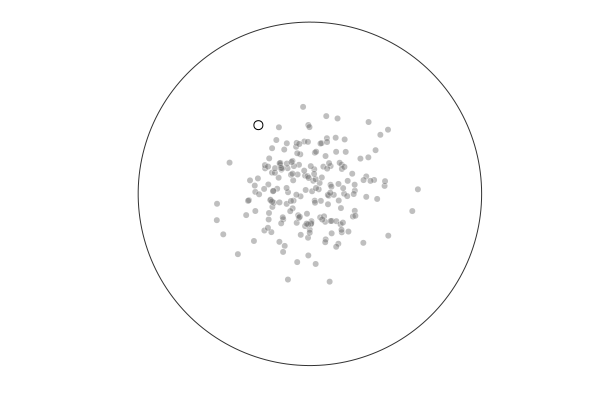

In [627]:
arena(randn(200).*0.2, randn(200).*0.2, color=:black, markeralpha=0.25)
scatter!([x], [y], color=:white, markerstrokecolor=:black, markersize=5)

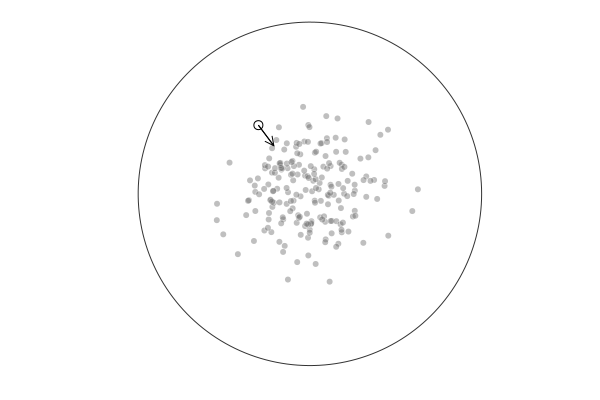

In [628]:
quiver!([x], [y], quiver=(-[x*0.3], -[y.*0.3]), color=:black)

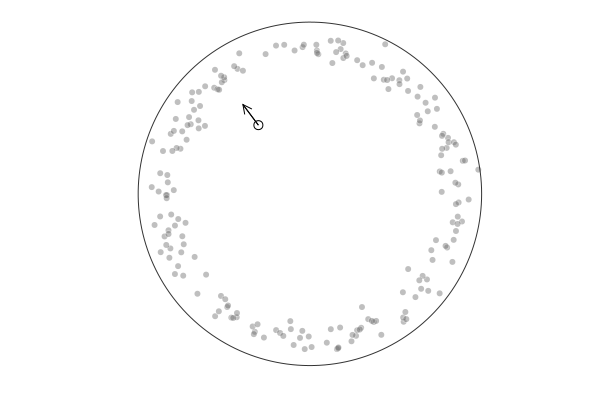

In [629]:
srand(2)
θ = rand(200) * 2π
ρ = randn(200) * .05 + 0.85

arena(cos.(θ).*ρ, sin.(θ).*ρ, markeralpha=0.25, color=:black)
scatter!([x], [y], color=:white, markerstrokecolor=:black, markersize=5)


quiver!([x], [y], quiver=([x*.3], [y*.3]), color=:black)

<div class="intro">

<p>but what is a</p>
<p class="big">context?</p>
<p>and how do you <em>know?</em></p>
</div>

In [472]:
recall1 = @where(recall, :subjid1 .== 7)

,subjid1,block,rep,respnr,line,rad,var,pred,new_block,correct,resp_time,new_rho_bias,rho,theta_resp,theta,rho_resp,rep_number,new_theta_resp,new_theta_bias,x,y,x_resp,y_resp,block_trial
1,7,1,1,1,1,0.0,0.01,0,true,0.0,6.49744,0.3678,-0.0913,2.449,0.1945,0.4591,20,0.878204,0.683704,-0.0142569,-0.00280846,-0.0562327,0.0466565,1
2,7,1,2,2,1,0.0,0.01,0,false,1.0,4.19923,0.6461,-0.056,-1.7976,0.04,0.7021,20,1.34399,1.30399,-0.00890555,-0.000356412,-0.0251269,-0.108881,2
3,7,1,3,3,1,0.0,0.01,0,false,1.0,2.8079,0.0882,-0.2734,-2.7804,-0.1535,0.3616,20,0.361193,0.514693,-0.0430013,0.00665304,-0.053837,-0.0203378,3
4,7,1,4,4,1,0.0,0.01,0,false,0.0,2.99417,-0.0662,-0.1492,1.4801,-0.0252,0.083,20,1.4801,1.5053,-0.0237384,0.000598334,0.00119644,0.0131556,4
5,7,1,5,5,1,0.0,0.01,0,false,0.0,3.50113,0.1658,-0.6481,-2.7731,0.0485,0.8139,20,0.368493,0.319993,-0.103027,-0.00500073,-0.120841,-0.0466602,5
6,7,1,6,6,1,0.0,0.01,0,false,0.0,1.76093,0.0101,0.3161,0.4533,0.0147,0.3261,20,0.4533,0.4386,0.0503034,0.000739514,0.0466588,0.022729,6
7,7,1,7,7,1,0.0,0.01,0,false,0.0,2.57978,0.6439,-0.1047,-2.5564,0.2155,0.7486,20,0.585193,0.369693,-0.0162781,-0.00356326,-0.0993186,-0.06581,7
8,7,1,8,8,1,0.0,0.01,0,false,0.0,2.05057,0.087,0.2363,-0.307,-0.0209,0.3234,20,-0.307,-0.2861,0.0376001,-0.000785957,0.0490642,-0.0155545,8
9,7,1,9,9,1,0.0,0.01,0,false,1.0,1.96827,0.0029,0.0684,2.8198,0.0093,0.0713,20,1.249,1.2397,0.0108857,0.00010124,-0.0107653,0.00358893,9
10,7,1,10,10,1,0.0,0.01,0,false,1.0,1.4834,-0.0595,0.2488,0.1194,-0.0849,0.1893,20,0.1194,0.2043,0.0394551,-0.00335781,0.0299135,0.00358875,10


In [582]:
r1_shuffled = view(recall1, randperm(size(recall1, 1)), :)
p = arena([], [], markeralpha=0.25, color=:black)
anim = @animate for (x,y) in @_ zip(r1_shuffled[:x], r1_shuffled[:y]) |> It.drop(_, 20) |> It.take(_, 100)
    push!(p, x,y)
end

gif(anim, "figures/shuffled.gif", fps=10)

INFO: Saved animation to /home/dave/.dropbox-raizadalab/Dropbox (Raizada Lab)/work/dots-location-memory-pernille/figures/shuffled.gif


Plots.AnimatedGif("/home/dave/.dropbox-raizadalab/Dropbox (Raizada Lab)/work/dots-location-memory-pernille/figures/shuffled.gif")

In [583]:
p = arena([], [], markeralpha=0.25, color=:black)
anim = @animate for (x,y) in @_ zip(recall1[:x], recall1[:y]) |> It.drop(_, 20) |> It.take(_, 100)
    push!(p, x,y)
end

gif(anim, "figures/clustered.gif", fps=10)

INFO: Saved animation to /home/dave/.dropbox-raizadalab/Dropbox (Raizada Lab)/work/dots-location-memory-pernille/figures/clustered.gif


Plots.AnimatedGif("/home/dave/.dropbox-raizadalab/Dropbox (Raizada Lab)/work/dots-location-memory-pernille/figures/clustered.gif")

# _Behavior_

In a structured environment recall is _biased_ towards clusters <span class="citation">[Robbins, Hemmer, and Tang, <em>CogSci2014</em>]</span>

In [533]:
known_recalled = by(recall, :subjid1) do d
    @_ KnownFilter(prior_optimized) |>
    RecallFilter(_, Matrix(0.01I,2,2)) |>
    filter!(_, extract_data(d, _)) |>
    DataFrame |>
    hcat(d, _) |>
    delete!(_, :subjid1) |>
    @transform(_, cosinesim = 1.-Distances.colwise(CosineDist(), 
                                                   hcat(:x_mod.-:x, :y_mod.-:y)', 
                                                   hcat(:x_resp.-:x, :y_resp.-:y)'))
end

known_recalled1 = @where(known_recalled, :subjid1 .== 7)



,subjid1,block,rep,respnr,line,rad,var,pred,new_block,correct,resp_time,new_rho_bias,rho,theta_resp,theta,rho_resp,rep_number,new_theta_resp,new_theta_bias,x,y,x_resp,y_resp,block_trial,x_mod,y_mod,rho_mod,cosinesim
1,7,1,1,1,1,0.0,0.01,0,true,0.0,6.49744,0.3678,-0.0913,2.449,0.1945,0.4591,20,0.878204,0.683704,-0.0142569,-0.00280846,-0.0562327,0.0466565,1,-0.0132152,-0.00238716,0.013429,-0.313957
2,7,1,2,2,1,0.0,0.01,0,false,1.0,4.19923,0.6461,-0.056,-1.7976,0.04,0.7021,20,1.34399,1.30399,-0.00890555,-0.000356412,-0.0251269,-0.108881,2,-0.0105424,-0.00113913,0.0106038,0.560021
3,7,1,3,3,1,0.0,0.01,0,false,1.0,2.8079,0.0882,-0.2734,-2.7804,-0.1535,0.3616,20,0.361193,0.514693,-0.0430013,0.00665304,-0.053837,-0.0203378,3,-0.0245999,0.00206974,0.0246868,-0.137223
4,7,1,4,4,1,0.0,0.01,0,false,0.0,2.99417,-0.0662,-0.1492,1.4801,-0.0252,0.083,20,1.4801,1.5053,-0.0237384,0.000598334,0.00119644,0.0131556,4,-0.0222496,0.00109296,0.0222765,0.989397
5,7,1,5,5,1,0.0,0.01,0,false,0.0,3.50113,0.1658,-0.6481,-2.7731,0.0485,0.8139,20,0.368493,0.319993,-0.103027,-0.00500073,-0.120841,-0.0466602,5,-0.0489626,-0.000733569,0.0489681,-0.464292
6,7,1,6,6,1,0.0,0.01,0,false,0.0,1.76093,0.0101,0.3161,0.4533,0.0147,0.3261,20,0.4533,0.4386,0.0503034,0.000739514,0.0466588,0.022729,6,-0.00794985,0.000371918,0.00795855,0.157284
7,7,1,7,7,1,0.0,0.01,0,false,0.0,2.57978,0.6439,-0.1047,-2.5564,0.2155,0.7486,20,0.585193,0.369693,-0.0162781,-0.00356326,-0.0993186,-0.06581,7,-0.021305,-0.000640584,0.0213146,0.390263
8,7,1,8,8,1,0.0,0.01,0,false,0.0,2.05057,0.087,0.2363,-0.307,-0.0209,0.3234,20,-0.307,-0.2861,0.0376001,-0.000785957,0.0490642,-0.0155545,8,-0.00475219,-0.000383615,0.00476765,-0.620665
9,7,1,9,9,1,0.0,0.01,0,false,1.0,1.96827,0.0029,0.0684,2.8198,0.0093,0.0713,20,1.249,1.2397,0.0108857,0.00010124,-0.0107653,0.00358893,9,-0.00792458,-0.000349022,0.00793226,0.983184
10,7,1,10,10,1,0.0,0.01,0,false,1.0,1.4834,-0.0595,0.2488,0.1194,-0.0849,0.1893,20,0.1194,0.2043,0.0394551,-0.00335781,0.0299135,0.00358875,10,0.00152253,-0.000793549,0.00171692,0.846301


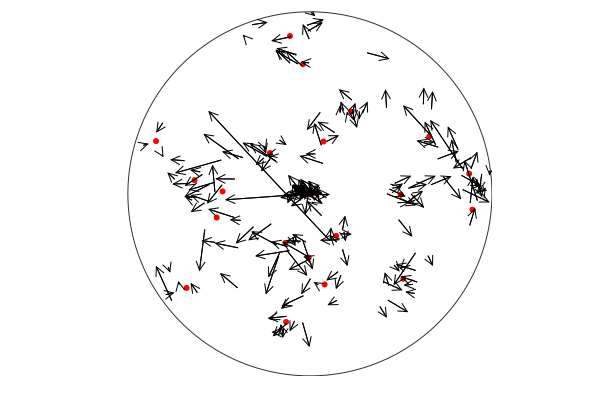

In [584]:
arena(lims=(-1,1))
@_ known_recalled1 |>
    @by(_, :block, x_clus = mean(:x), y_clus = mean(:y)) |>
    @df(_, scatter!(:x_clus, :y_clus, color=:red, seriestype=:scatter, markerstrokecolor=:white))
@df recall1 quiver!(:x, :y, quiver=(:x_resp.-:x, :y_resp.-:y), color=:black, seriestype=:quiver, lims=(-1,1))

# _Behavior_ + <em><span style="color:red">cluster bias</span></em>

In a structured environment recall is _biased_ towards clusters <span class="citation">[Robbins, Hemmer, and Tang, <em>CogSci2014</em>]</span>

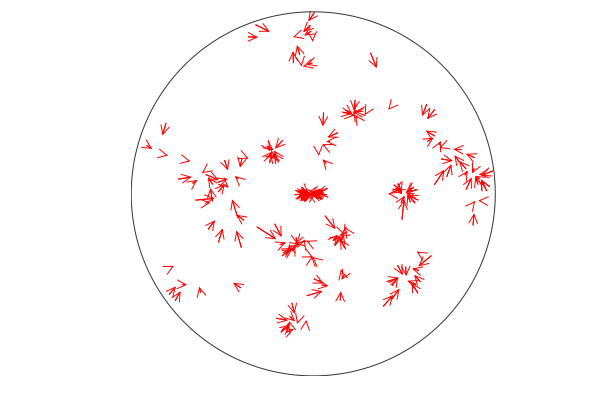

In [477]:
@df known_recalled1 arena(:x, :y, quiver=(:x_mod.-:x, :y_mod.-:y), seriestype=:quiver, color=:red)

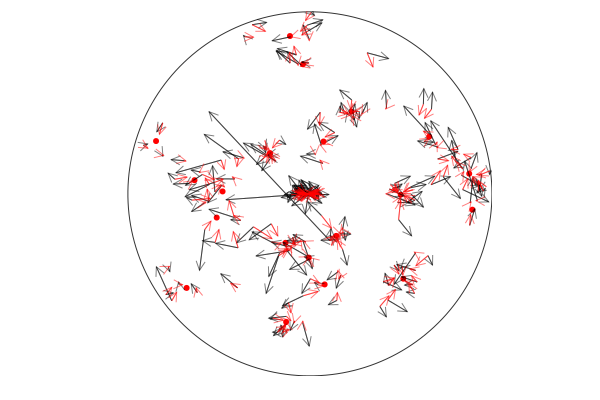

In [585]:
arena(lims=(-1,1))
@_ known_recalled1 |>
    @by(_, :block, x_clus = mean(:x), y_clus = mean(:y)) |>
    @df(_, scatter!(:x_clus, :y_clus, color=:red, seriestype=:scatter, markerstrokecolor=:white))
@df known_recalled1 quiver!(:x, :y, quiver=(:x_resp.-:x, :y_resp.-:y), color=GrayA(0.0, 0.5))
@df known_recalled1 quiver!(:x, :y, quiver=(:x_mod.-:x, :y_mod.-:y), color=RGBA(1, 0, 0, 0.5))


# _Learning_ contexts

## _Computational-level_: Dirichlet Process mixture model

* _Infer_ how points $x_t$ are assigned $z_t$
    * $p(z_1, \ldots, z_T | x_1, \ldots, x_T) \propto p(x_1, \ldots, x_T | z_1, \ldots, z_T) p(z_1, \ldots, z_T)$
* Prior: "sticky" CRP $p(z_t = j | z_{1\ldots t-1}) \propto N_j (\times \frac{\rho}{1-\rho}$ if $z_{t-1}=j)$
    * $N_j = \alpha$ for all new $j$.
    * Prefer **small number** of contexts
    * Allow for up to $T$ (one per point)
* Likelihood: $p(x_t | z_t, z_{1:t-1}, x_{1:t-1})$
    * Prefer **compact clusters**

# TODO: examples of high/low prior/likelihood

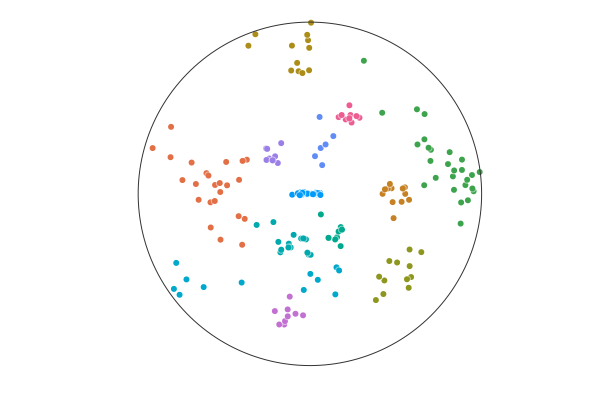

In [586]:
# high likelihood, high prior:
@df recalled1 arena(:x, :y, group=assignments(first(particles(rf))), markerstrokecolor=GrayA(1., 0.5))

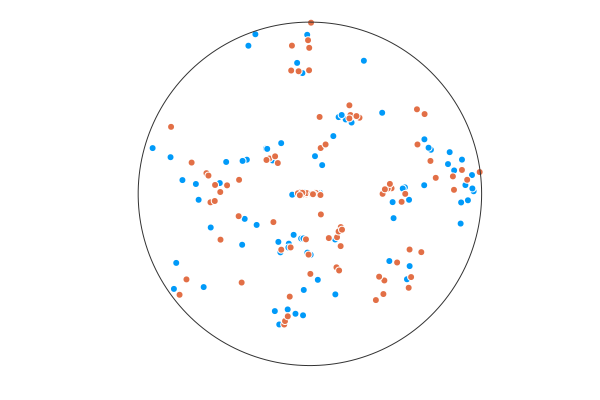

In [587]:
# same prior, low likelihood:
@df recalled1 arena(:x, :y, group=StatsBase.sample([1,2], 200; replace=true))

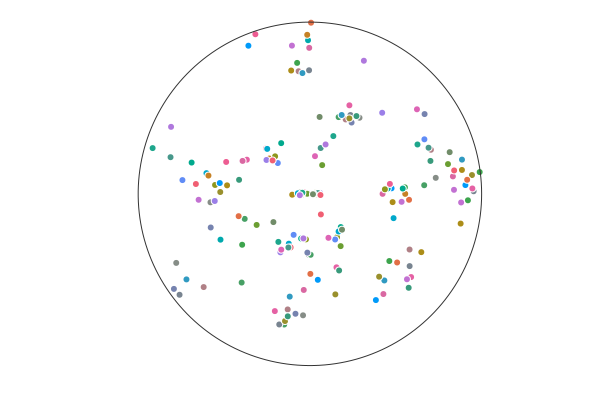

In [588]:
@df recalled1 arena(:x, :y, group=1:200)

# Learning _contexts_

<h2 class="old"><em>Computational-level</em></h2>

## _Algorithmic-level_: Sequential Monte Carlo

* **online** (not batch)
* **finite** uncertainty
* particle filter:
    * Each particle is one hypothetical clustering $z_{1\ldots t}$
    * Update particles in parallel following new data point
    * Re-sample when particles become too homogenous

# Does it _work_?

## Learning clusters

## Recall

## Prediction

In [482]:
rf = RecallFilter(ChenLiuParticles(100, prior_optimized, StickyCRP(0.01, 0.9)), Matrix(0.01I,2,2))
filter!(rf, extract_data(recall1, rf))

recalled1 = hcat(recall1, DataFrame(rf))

rf_crp = RecallFilter(ChenLiuParticles(100, prior_optimized, ChineseRestaurantProcess(0.01)), Matrix(0.01I,2,2))
filter!(rf_crp, extract_data(recall1, rf_crp))
crp_recalled1 = hcat(recall1, DataFrame(rf_crp))

sort!(particles(rf), by=weight, rev=true)
sort!(particles(rf_crp), by=weight)

Fitting particles...100%|███████████████████████████████| Time: 0:00:05
Fitting particles...100%|███████████████████████████████| Time: 0:00:05


100-element Array{Particles.InfiniteParticle{ConjugatePriors.NormalInverseWishart{Float64},Distributions.MvNormalStats,Particles.ChineseRestaurantProcess},1}:
 9+ Particle 
 9+ Particle 
 9+ Particle 
 9+ Particle 
 9+ Particle 
 9+ Particle 
 9+ Particle 
 9+ Particle 
 9+ Particle 
 9+ Particle 
 10+ Particle
 9+ Particle 
 9+ Particle 
 ⋮           
 9+ Particle 
 9+ Particle 
 9+ Particle 
 10+ Particle
 9+ Particle 
 9+ Particle 
 9+ Particle 
 9+ Particle 
 10+ Particle
 9+ Particle 
 9+ Particle 
 9+ Particle 

# _Learning_ clusters

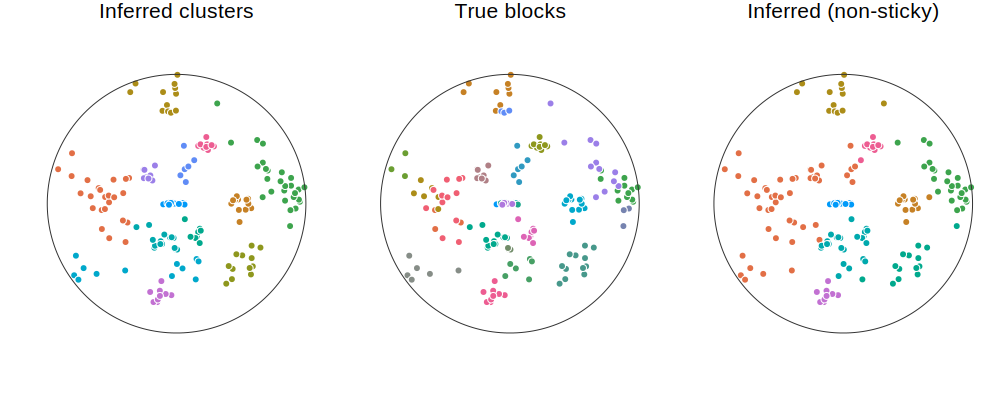

In [589]:
@df recalled1 plot(arena(:x, :y, group=assignments(first(particles(rf))), title="Inferred clusters"),
                   arena(:x, :y, group=:block, title="True blocks"),
                   arena(:x, :y, group=assignments(first(particles(rf_crp))), title="Inferred (non-sticky)"),
                   layout=(1,3), size=(1000, 400))

# _Learning_ clusters

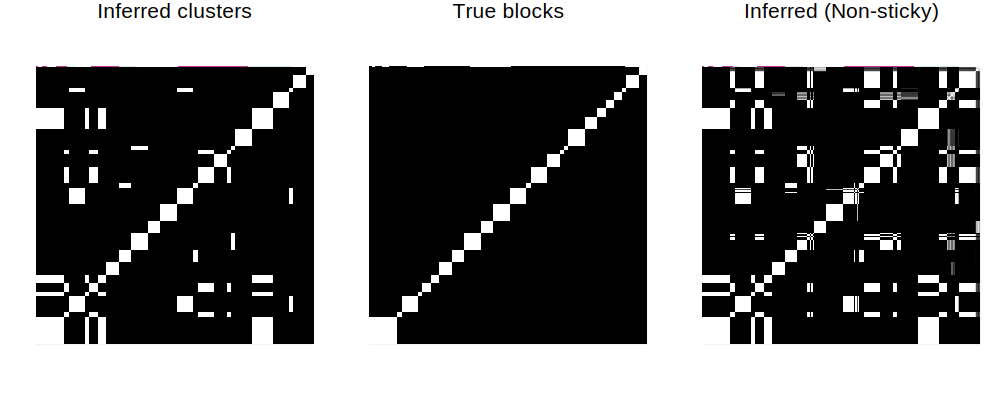

In [590]:
plot(plot(show_assignment_similarity(rf), title="Inferred clusters"),
     plot(Gray.(@with(recall1, :block .== :block')), title="True blocks"),
     plot(show_assignment_similarity(rf_crp), title="Inferred (Non-sticky)"),
     axis=false, aspect_ratio=:equal, layout=(1,3), size=(1000,400))

# _Recall_

## _Task_

* Immediate recall with mask

## _Model_

* Bayesian cue combination (after e.g., Huttenlocher)
* two cues: thing you saw, and inferred context
* weighted average (by inverse-variance)

In [208]:
# result:
#   .experiment:
#     .data:
#     - (recall1, recall2, ...)
#     - (pred1, pred2, ...)
#   .result
#   - (recalled1, predicted1)
#   - (recalled2, predicted2)
#   - ...

function add_params!(df::AbstractDataFrame, params)
    for (k,v) in params
        df[k] = v
    end
    df
end

# extract input data (which is by subject) and predictions
recalled(r) =
    add_params!(hcat(vcat(r.experiment.data[1]...),
                     vcat(first.(r.result)...)),
                r.experiment.params)

predicted(r) =
    add_params!(hcat(vcat(r.experiment.data[2]...),
                     vcat(last.(r.result)...)[[:xys_mod]]),
                r.experiment.params)

predicted (generic function with 1 method)

In [209]:
recalled_all = mapreduce(recalled, vcat, results)

,subjid1,block,rep,respnr,line,rad,var,pred,new_block,correct,resp_time,new_rho_bias,rho,theta_resp,theta,rho_resp,rep_number,new_theta_resp,new_theta_bias,x,y,x_resp,y_resp,x_mod,y_mod,rho_mod,α,ρ,Sσ,batch,n,iter,prior
1,1.0,1.0,1.0,1.0,1.0,0.0,0.01,0.0,0.0,1.0,3.86993,0.0677,0.2032,-1.8158,0.1749,0.2709,20.0,1.32579,1.15089,0.0318469,0.00562752,-0.010458,-0.0418275,0.0318544,0.00563721,0.0323494,0.01,0.1,0.0001,run2,100,1,"ConjugatePriors.NormalInverseWishart{Float64}( dim: 2 zeromean: false mu: [0.0433458, 0.0204879] kappa: 0.0255664 Lamchol: Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor: [0.0723856 0.0; 0.0 0.0723856] nu: 2.78446 )"
2,1.0,1.0,2.0,2.0,1.0,0.0,0.01,0.0,0.0,0.0,4.89866,-0.1162,0.1751,-0.5191,0.0133,0.0589,20.0,-0.5191,-0.5324,0.0278656,0.000370634,0.00813932,-0.00465054,0.0279637,0.000499986,0.0279681,0.01,0.1,0.0001,run2,100,1,"ConjugatePriors.NormalInverseWishart{Float64}( dim: 2 zeromean: false mu: [0.0433458, 0.0204879] kappa: 0.0255664 Lamchol: Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor: [0.0723856 0.0; 0.0 0.0723856] nu: 2.78446 )"
3,1.0,1.0,3.0,3.0,1.0,0.0,0.01,0.0,0.0,1.0,3.27847,0.3643,-0.1007,-2.7553,0.0325,0.465,20.0,0.386293,0.353793,-0.0160184,-0.000520783,-0.0685536,-0.0278827,-0.0144499,-0.00039846,0.0144554,0.01,0.1,0.0001,run2,100,1,"ConjugatePriors.NormalInverseWishart{Float64}( dim: 2 zeromean: false mu: [0.0433458, 0.0204879] kappa: 0.0255664 Lamchol: Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor: [0.0723856 0.0; 0.0 0.0723856] nu: 2.78446 )"
4,1.0,1.0,4.0,4.0,1.0,0.0,0.01,0.0,0.0,0.0,5.18263,0.1782,0.318,-0.4571,-0.0794,0.4962,20.0,-0.4571,-0.3777,0.0504518,-0.00401431,0.070865,-0.0348544,0.048923,-0.00365995,0.0490597,0.01,0.1,0.0001,run2,100,1,"ConjugatePriors.NormalInverseWishart{Float64}( dim: 2 zeromean: false mu: [0.0433458, 0.0204879] kappa: 0.0255664 Lamchol: Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor: [0.0723856 0.0; 0.0 0.0723856] nu: 2.78446 )"
5,1.0,1.0,5.0,5.0,1.0,0.0,0.01,0.0,0.0,0.0,2.16899,0.6045,-0.1964,-0.7403,0.0315,0.8009,20.0,-0.7403,-0.7718,-0.0312425,-0.000984465,0.0941047,-0.0859778,-0.0288976,-0.000884699,0.0289112,0.01,0.1,0.0001,run2,100,1,"ConjugatePriors.NormalInverseWishart{Float64}( dim: 2 zeromean: false mu: [0.0433458, 0.0204879] kappa: 0.0255664 Lamchol: Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor: [0.0723856 0.0; 0.0 0.0723856] nu: 2.78446 )"
6,1.0,1.0,6.0,6.0,1.0,0.0,0.01,0.0,0.0,1.0,3.50085,0.2961,0.0535,-2.0718,-0.0527,0.3496,20.0,1.06979,1.12249,0.00850297,-0.000448522,-0.0267245,-0.0488024,0.00872238,-0.000389493,0.00873107,0.01,0.1,0.0001,run2,100,1,"ConjugatePriors.NormalInverseWishart{Float64}( dim: 2 zeromean: false mu: [0.0433458, 0.0204879] kappa: 0.0255664 Lamchol: Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor: [0.0723856 0.0; 0.0 0.0723856] nu: 2.78446 )"
7,1.0,1.0,7.0,7.0,1.0,0.0,0.01,0.0,0.0,1.0,2.95322,0.4522,0.1975,0.0,0.0932,0.6497,20.0,0.0,-0.0932,0.0312967,0.00292533,0.103403,0.0,0.0301588,0.00263369,0.0302736,0.01,0.1,0.0001,run2,100,1,"ConjugatePriors.NormalInverseWishart{Float64}( dim: 2 zeromean: false mu: [0.0433458, 0.0204879] kappa: 0.0255664 Lamchol: Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor: [0.0723856 0.0; 0.0 0.0723856] nu: 2.78446 )"
8,1.0,1.0,8.0,8.0,1.0,0.0,0.01,0.0,0.0,1.0,3.21443,0.3549,0.2248,-1.8647,0.1165,0.5797,20.0,1.27689,1.16039,0.0355355,0.00415872,-0.0267275,-0.0883059,0.0341805,0.00374106,0.0343846,0.01,0.1,0.0001,run2,100,1,"ConjugatePriors.NormalInverseWishart{Float64}( dim: 2 zeromean: false mu: [0.0433458, 0.0204879] kappa: 0.0255664 Lamchol: Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor: [0.0723856 0.0; 0.0 0.0723856] nu: 2.78446 )"
9,1.0,1.0,9.0,9.0,1.0,0.0,0.01,0.0,0.0,0.0,2.29494,0.105,-0.0469,2.5269,-0.2046,0.1519,20.0,0.956104,1.1607,-0.00730868,0.00151658,-0.0197503,0.0139423,-0.0055706,0.00140054,0.00574396,0.01,0.1,0.0001,run2,100,1,"ConjugatePriors.NormalInverseWishart{Float64}( di

In [210]:
cosinesim(d) = cosinesim(d,d)
mse(d) = mse(d,d)

recalled_summaries = by(recalled_all, [:α, :ρ, :Sσ], d -> DataFrame(cos=cosinesim(d), mse=mse(d)))

,α,ρ,Sσ,cos,mse
1,0.01,0.1,0.0001,0.092649,0.118958
2,0.1,0.1,0.0001,0.0825791,0.118964
3,1.0,0.1,0.0001,0.0799714,0.118976
4,10.0,0.1,0.0001,0.0763705,0.118996
5,0.01,0.5,0.0001,0.100513,0.11894
6,0.1,0.5,0.0001,0.0957552,0.118947
7,1.0,0.5,0.0001,0.0925236,0.118956
8,10.0,0.5,0.0001,0.0877857,0.118972
9,0.01,0.9,0.0001,0.111026,0.118928
10,0.1,0.9,0.0001,0.103473,0.118935


rec_params_good = @_(((recalled_summaries |> @where(_, :Sσ .≈ 0.01)) |> sort!(_, :cos, rev=true)) |> head(_, 1)) = 1×5 DataFrames.DataFrame
│ Row │ α    │ ρ   │ Sσ   │ cos     │ mse      │
├─────┼──────┼─────┼──────┼─────────┼──────────┤
│ 1   │ 0.01 │ 0.9 │ 0.01 │ 0.11091 │ 0.123901 │


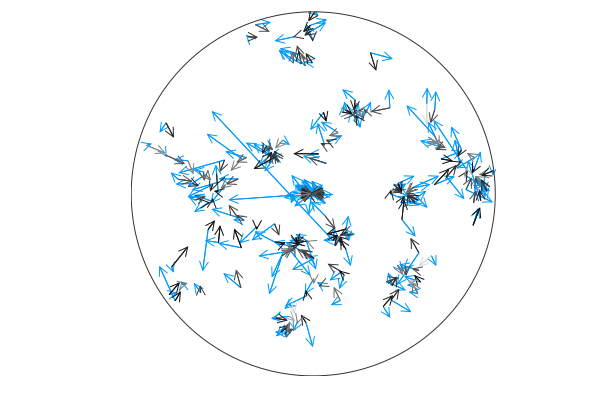

In [427]:
# get a good parameter setting (one where cosine similarity is high and Sσ is high enough to see)
@show rec_params_good = @_ recalled_summaries |>
    @where(_, :Sσ .≈ 0.01) |>
    sort!(_, :cos, rev=true) |> 
    head(_, 1) 

# average over iterations
recalled_good = @_ rec_params_good |>
    join(recalled_all, _, on=[:α, :ρ, :Sσ]) |>
    @by(_, [:subjid1, :block, :rep, :rep_number, :respnr, :rad, :var, :x, :y, :x_resp, :y_resp],
        x_mod = mean(:x_mod), y_mod = mean(:y_mod)) 


recalled1 = @_ recalled_good |>
    @where(_, :subjid1 .== 7)

@df(recalled1, begin
    arena(:x, :y, quiver=(:x_resp .- :x, :y_resp .- :y), seriestype=:quiver)
    quiver!(:x, :y, quiver=(:x_mod .- :x, :y_mod .- :y), line_z=:rep, color=:grays)
    end)

In [428]:
baseline!(df) = @_ df |>
    @transform(_, gt_rho_avg = rho.(:x,:y) .> mean(rho.(:x, :y))) |>
    # @with(_, (hcat(:x,:y) .* ifelse.(:gt_rho_avg, -1, 1))')
    @transform(_, cos_center = 1 .- Distances.colwise(CosineDist(),
                                                      -hcat(:x, :y)', 
                                                      hcat(:x_resp.-:x, :y_resp.-:y)'),
                  cos_mean_rho = 1 .- Distances.colwise(CosineDist(),
                                                        (hcat(:x,:y) .* ifelse.(:gt_rho_avg, -1, 1))',
                                                        hcat(:x_resp.-:x, :y_resp.-:y)'),
                  cos_mod = 1 .- Distances.colwise(CosineDist(),
                                                   hcat(:x_mod.-:x, :y_mod.-:y)',
                                                   hcat(:x_resp.-:x, :y_resp.-:y)'))


baseline_good = baseline!(recalled_good)
bs_center, bs_avgrho = @_ baseline_good |>
    @where(_, (!isnan).(:cos_center)) |>    # there is one trial with zero deviation...
    @with(_, (mean(:cos_center), mean(:cos_mean_rho)))

(0.0649553468202671, 0.06137345972690474)

* works best for high stickiness, low clustering (fewer clusters).  but all work about the same

# _Recall_: <span class="model">model</span>

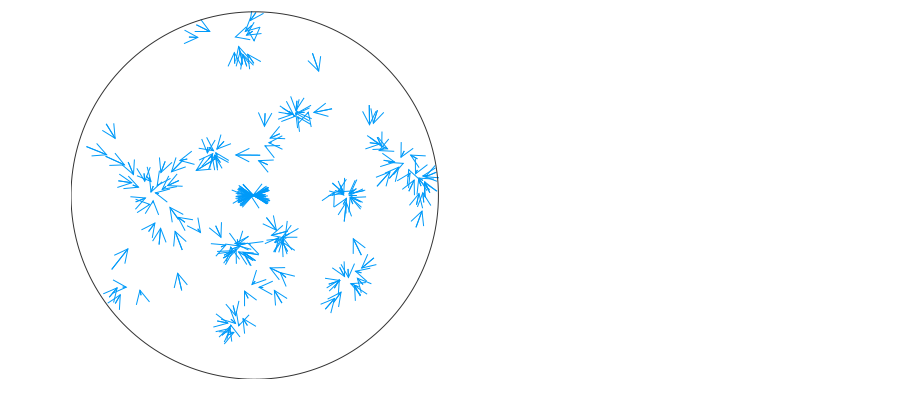

In [591]:
size2 = (900,400)

p1 = @df recalled1 arena(:x, :y, quiver=(:x_mod.-:x, :y_mod.-:y), seriestype=:quiver, label="Model",
                         layout=@layout([a{0.5w} _]), size=size2)

# _Recall_: <span class="model">model</span> + behavior

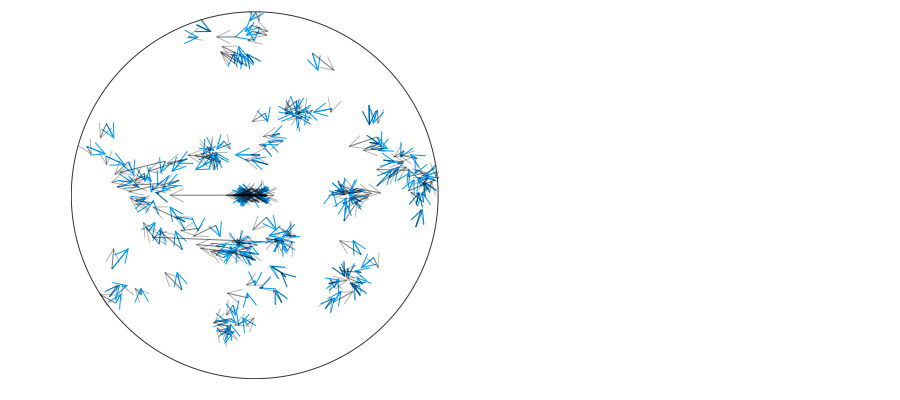

In [437]:
@df recalled1 quiver!(:x, :y, quiver=(:x_resp.-:x, :y_mod.-:y), color=GrayA(0.0, 0.3), label="Behavior", subplot=1)

# _Recall_: <span class="model">model</span> + behavior

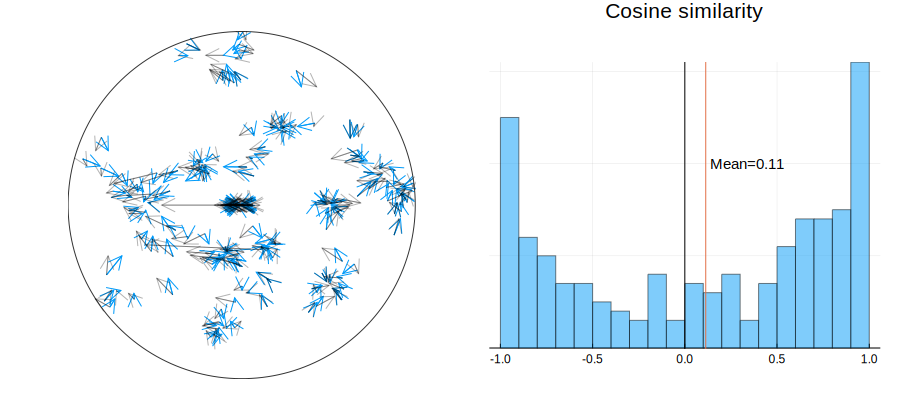

In [487]:
@_ baseline_good |>
    @where(_, :subjid1 .== 7) |>
    @df _ begin
        plot(arena(:x, :y, quiver=(:x_mod.-:x, :y_mod.-:y), seriestype=:quiver),
             histogram(:cos_mod, bins=20, normalized=true, yaxis=false, label="", 
                       legend=false,
                       aspect_ratio=:equal, 
                       alpha=0.5),
             layout=@layout([a{0.5w} b]), size=size2)
        quiver!(:x, :y, quiver=(:x_resp.-:x, :y_mod.-:y), color=GrayA(0.0, 0.3), label="Behavior", subplot=1)
        vline!([cosinesim(baseline_good)], subplot=2)
        vline!([0], subplot=2, color=:black)
        annotate!(cosinesim(baseline_good)*1.2, 1, text("Mean=$(round(cosinesim(baseline_good), 2))", 10, :left),
                  subplot=2)
        title!("Cosine similarity", subplot=2)
    end



# _Recall_: overall fit

depends on _stickiness_ (<span class="blue">low</span> &lt; <span class="red">medium</span> &lt; <span class="green">high</span>) and eagerness to create _new clusters_


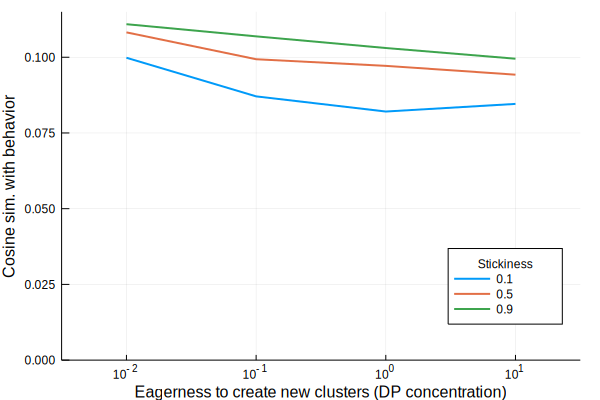

In [636]:
@df(@where(recalled_summaries, :Sσ .≈ 0.01),
    plot(:α, :cos, group=:ρ, xscale=:log10, 
         xlims=(10^-2.5, 10^1.5), ylims=(0, 0.115), seriestype=:line,
         xlabel="Eagerness to create new clusters (DP concentration)",
         ylabel=("Cosine sim. with behavior"),
        legend=:bottomright, legend_title="Stickiness", line=2))

# _Recall_: baselines

consistently **&approx; known clusters** and **&gt; center/mean radius**

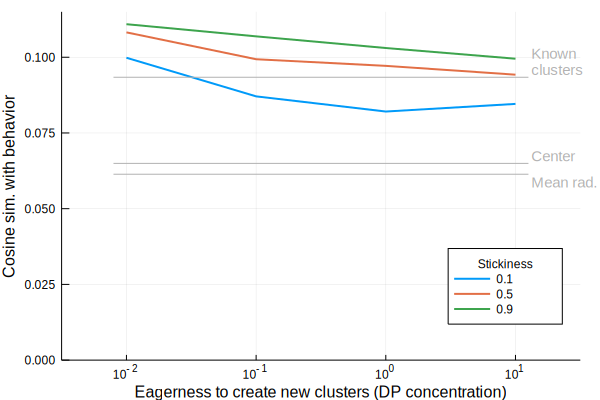

In [637]:
# @df(@where(recalled_summaries, :Sσ .≈ 0.01),
#     plot(:α, :cos, group=:ρ, xscale=:log10, 
#          xlims=(10^-2.5, 10^1.5), ylims=(0, 0.115), seriestype=:line,
#          xlabel="Eagerness to create new clusters (DP concentration)",
#          ylabel=("Cosine sim. with behavior"),
#         legend=:bottomright, legend_title="Stickiness", line=2))

baseline_x = [10^-2.1, 10^1.1]

function plot_baseline!(y, label)
    plot!(baseline_x, ones(2)*y, color=Gray(0.7), label="")
    annotate!(baseline_x[end]*1.05, y, label)
end

plot_baseline!(cosinesim(known_recalled), text("Known\nclusters", 10, RGB(Gray(0.7)), :left, :bottom))

plot_baseline!(bs_center, text("Center", 10, RGB(Gray(0.7)), :left, :bottom))
plot_baseline!(bs_avgrho, text("Mean rad.", 10, RGB(Gray(0.7)), :left, :top))

In [300]:
@_ baseline_good |>
    @where(_, (!isnan).(:cos_center)) |>
    @by(_, :rad, 
        mod_gt_center = mean(:cos_mod .> :cos_center), 
        mod_minus_center = mean(:cos_mod .- :cos_center),
        mod_gt_meanrho = mean(:cos_mod .> :cos_mean_rho),
        mod_minus_meanrho = mean(:cos_mod .- :cos_mean_rho)) |>
    sort!(_, :rad)

,rad,mod_gt_center,mod_minus_center,mod_gt_meanrho,mod_minus_meanrho
1,0.0,0.498575,-0.0812969,0.538462,0.120497
2,0.3,0.490385,0.0762239,0.487179,0.0384403
3,0.5,0.541667,0.194667,0.491071,0.0499183
4,0.7,0.505952,0.0340896,0.502976,0.0201662
5,0.9,0.488636,0.024308,0.488636,0.024308


In [301]:
@_ baseline_good |>
    @where(_, (!isnan).(:cos_center)) |>
    @by(_, :subjid1, 
        mod_gt_center = mean(:cos_mod .> :cos_center), 
        mod_minus_center = mean(:cos_mod .- :cos_center),
        mod_gt_meanrho = mean(:cos_mod .> :cos_mean_rho),
        mod_minus_meanrho = mean(:cos_mod .- :cos_mean_rho))

,subjid1,mod_gt_center,mod_minus_center,mod_gt_meanrho,mod_minus_meanrho
1,1.0,0.485,-0.0325187,0.52,0.103564
2,2.0,0.445,-0.0358331,0.59,0.243624
3,3.0,0.465,-0.0592764,0.44,-0.0663509
4,4.0,0.55,0.239,0.535,0.110566
5,5.0,0.515,0.073145,0.54,0.114792
6,6.0,0.425,-0.106147,0.39,-0.130987
7,7.0,0.615,0.342142,0.545,0.196496
8,8.0,0.547739,-0.0280205,0.462312,-0.151192


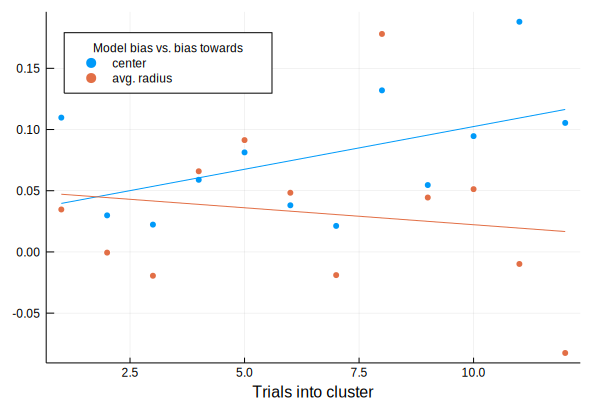

In [592]:
@_ baseline_good |>
    @where(_, (!isnan).(:cos_center), :block .> 1) |>
    @by(_, :rep, 
        mod_gt_center = mean(:cos_mod .> :cos_center), 
        mod_minus_center = mean(:cos_mod .- :cos_center),
        mod_gt_meanrho = mean(:cos_mod .> :cos_mean_rho),
        mod_minus_meanrho = mean(:cos_mod .- :cos_mean_rho)) |>
    @df(_, scatter(:rep, hcat(:mod_minus_center, :mod_minus_meanrho), smooth=true,
                   label=["center", "avg. radius"], legend_title="Model bias vs. bias towards", legend=:topleft,
                   xlabel="Trials into cluster"))

In [530]:
@_ baseline_scores |>
    @where(_, (!isnan).(:cos_center), :block .> 1) |>
    @by(_, :rep, 
        mod_gt_center = mean(:cos_mod .> :cos_center), 
        mod_minus_center = mean(:cos_mod .- :cos_center),
        mod_gt_meanrho = mean(:cos_mod .> :cos_mean_rho),
        mod_minus_meanrho = mean(:cos_mod .- :cos_mean_rho)) |>
    sort!(_, :rep)

,rep,mod_gt_center,mod_minus_center,mod_gt_meanrho,mod_minus_meanrho
1,1.0,0.523066,0.0770593,0.502647,0.00201573
2,2.0,0.497483,0.0314335,0.471962,0.00100509
3,3.0,0.516942,0.0174442,0.480787,-0.0243242
4,4.0,0.516088,0.0372031,0.499016,0.0441662
5,5.0,0.498669,0.084033,0.513426,0.0940678
6,6.0,0.45733,-0.0464895,0.461574,-0.0362443
7,7.0,0.470775,0.0276892,0.4807,-0.0124996
8,8.0,0.545139,0.120064,0.578443,0.166145
9,9.0,0.510677,0.0369216,0.526476,0.026725
10,10.0,0.535475,0.0805416,0.532002,0.0372218


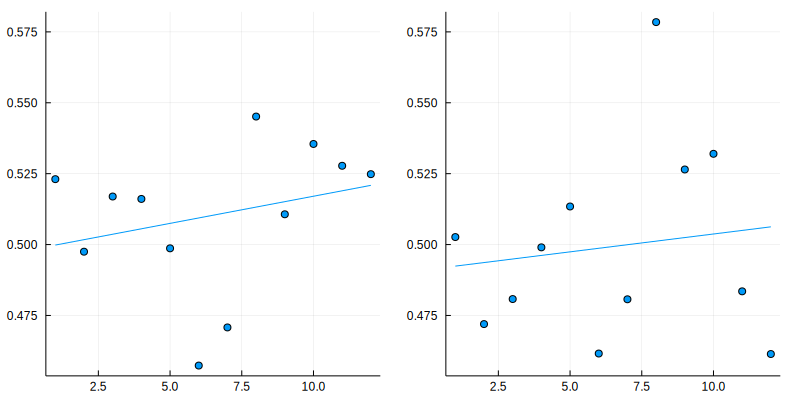

In [529]:
@_ baseline_scores |>
    @where(_, (!isnan).(:cos_center)) |>
    @where(_, :block .> 1) |>
    @by(_, [:rep], 
        mod_gt_center = mean(:cos_mod .> :cos_center), 
        mod_minus_center = mean(:cos_mod .- :cos_center),
        mod_gt_meanrho = mean(:cos_mod .> :cos_mean_rho),
        mod_minus_meanrho = mean(:cos_mod .- :cos_mean_rho)) |>
    @df(_, plot(scatter(:rep, :mod_gt_center, smooth=true),
                scatter(:rep, :mod_gt_meanrho, smooth=true),
                size=(800, 400), legend=false, link=:y))

# _Prediction_

## _Task_

* Interleaved with recall task (every three trials)
* Predict location 1, 5, or 10 trials in future

## _Model_

* Sample one particle
* Sample $n$ steps from particle's sticky Chinese Restaurant Process prior on states
* Draw one point from posterior predictive of sampled cluster

In [450]:
predicted_all = @_ vcat([predicted(r) for r in results]...) |>
    @by(_, [:subjid1, :block, :respnr, :pred, :theta_resp, :rho_resp, :α, :ρ], xys_mod = (:xys_mod...)) |>
    @transform(_, subjid1 = Int.(:subjid1),
                  block = Int.(:block), 
                  respnr = Int.(:respnr),
                  x_resp = cos.(:theta_resp) .* :rho_resp./2π,
                  y_resp = sin.(:theta_resp) .* :rho_resp./2π,
                  xys_mod = [vcat(xym...) for xym in :xys_mod])

predicted_good = @_ predicted_all |>
    join(_, delete!(copy(rec_params_good), :Sσ), on=[:α, :ρ]) |>
    join(_, @select(recall, :subjid1, :block, :respnr, :x, :y), 
            on=[:subjid1, :block, :respnr]) |>
    sort!(_, (:subjid1, :respnr, :pred))

predicted1 = @where(predicted_good, :subjid1 .== 7);

In [594]:
white_to_black = cgrad([Gray(.9), Gray(0)])

function plot_prediction_task(xys_mod::Matrix, 
                              x::Float64, y::Float64, 
                              x_resp::Float64, y_resp::Float64)
    p = arena(xys_mod[:,1], xys_mod[:,2], seriestype=:histogram2d, color=white_to_black, 
              bins=linspace(-1.2, 1.2, 50), lims=(-1.2, 1.2))
    scatter!(p, [x], [y], color=:white, markerstrokecolor=Gray(.5))
    scatter!(p, [x_resp], [y_resp], color=:red)
    return p
end

function plot_prediction_task(d::AbstractDataFrame, args...; title=true, kwargs...)
    plots = let plots = [], title=title
        @byrow! d begin
            push!(plots, plot_prediction_task(:xys_mod, :x, :y, :x_resp, :y_resp))
            title!(plots[end], title ? "Trial $(:respnr) (+$(:pred))" : "")
        end
        plots
    end
    plot(plots..., args...; kwargs...)
end


plot_prediction_task (generic function with 2 methods)

# _Prediction_: model + <span style="color:red">behavior</span>

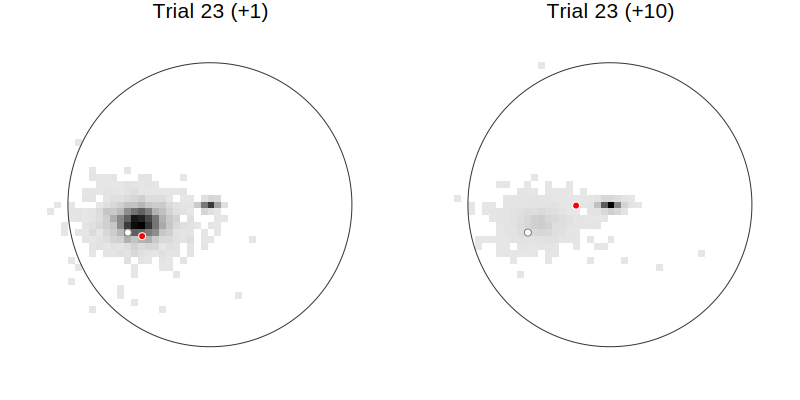

In [595]:
@_ predicted1 |>
    @where(_, :respnr .== 23) |>
    plot_prediction_task(_, title=true, size=(800,400))


# _Prediction_: model + <span style="color:red">behavior</span>

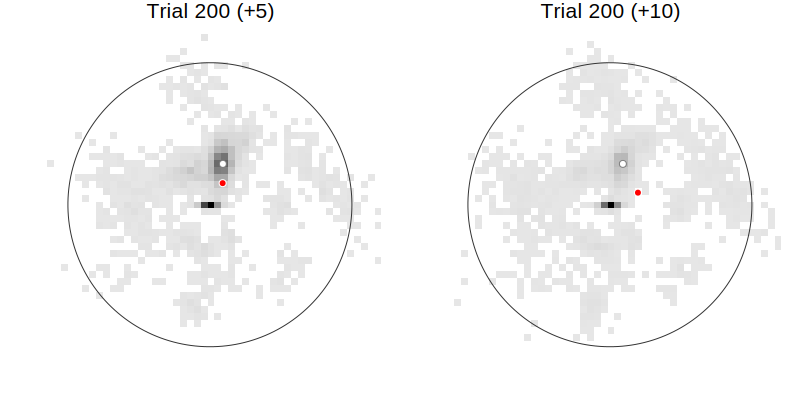

In [596]:
plot_prediction_task(predicted1[end-1:end,:], size=(800, 400))

# _Prediction_: model + <span style="color:red">behavior</span>

In [597]:
let anim = Animation()
    @byrow! predicted1 begin
        plot_prediction_task(:xys_mod, :x, :y, :x_resp, :y_resp)
        title!("Trial $(:respnr) (+$(:pred))")
        frame(anim)
    end
    gif(anim, "figures/pred1.gif", fps=1)
end


INFO: Saved animation to /home/dave/.dropbox-raizadalab/Dropbox (Raizada Lab)/work/dots-location-memory-pernille/figures/pred1.gif


Plots.AnimatedGif("/home/dave/.dropbox-raizadalab/Dropbox (Raizada Lab)/work/dots-location-memory-pernille/figures/pred1.gif")

In [605]:
let anim = Animation(), rx = recalled1[:x], ry = recalled1[:y], rnr = recalled1[:respnr]
    @byrow! predicted1 begin
        p1 = plot_prediction_task(:xys_mod, :x, :y, :x_resp, :y_resp)
        title!("Trial $(:respnr) (+$(:pred))")
        p2 = arena(rx[rnr.<=:respnr], ry[rnr.<=:respnr], lims=(-1.2, 1.2), 
                   markeralpha=0.25, color=Gray(0), title="Studied")
        plot(p1, p2, size=(800, 400))
        frame(anim)
    end
    gif(anim, "figures/pred2.gif", fps=1)
end


INFO: Saved animation to /home/dave/.dropbox-raizadalab/Dropbox (Raizada Lab)/work/dots-location-memory-pernille/figures/pred2.gif


Plots.AnimatedGif("/home/dave/.dropbox-raizadalab/Dropbox (Raizada Lab)/work/dots-location-memory-pernille/figures/pred2.gif")

* How far away from the last point do people typically guess?

# _Prediction_: average distance

**model &approx; behavior**: distance of predictions at <span class="blue">1 trial</span> &lt; <span class="red">5 trials</span> &lt; <span class="green">10 trials</span> 

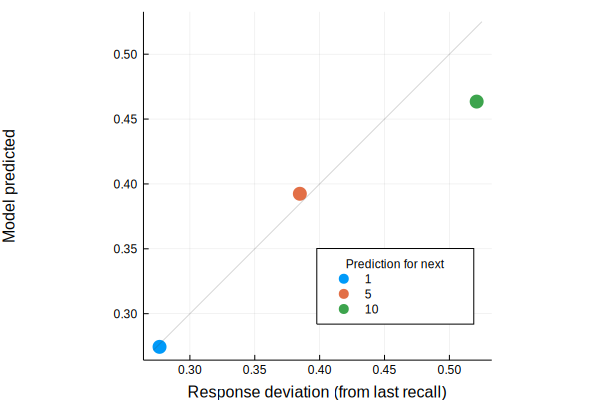

In [616]:
prediction_deviations = @_ predicted_good |>
    @transform(_, resp_dev = rho.(:x.-:x_resp, :y.-:y_resp), 
                  mod_dev = mean.(pairwise.(Euclidean(), 
                                            transpose.(hcat.(:x, :y)),
                                            transpose.(:xys_mod))))

@_ prediction_deviations |>
    @by(_, [:pred], resp_dev = mean(:resp_dev), mod_dev = mean(:mod_dev)) |>
    @df(_, begin 
        scatter(:resp_dev, :mod_dev, markersize=8, xlabel="Response deviation (from last recall)", ylabel="Model predicted", 
                group=:pred, legend=:bottomright, aspect_ratio=:equal, 
                legend_title="Prediction for next")
        #scatter!(:resp_dev, :mod_dev, markeralpha=0, color=:black, label="", smooth=true)
        end)


plot!(x->x, color=GrayA(0.2, 0.2), label="")

* even _within_ a prediction offset, there's some variability in the deviation of the prediction from the current point.
* ...and there's a postive relation between what the model 

# _Prediction_: single trial distance

captures variation _within_ prediction horizons

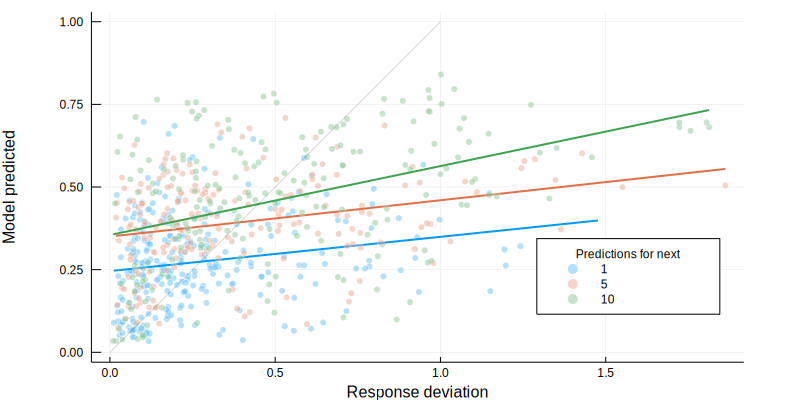

In [619]:
@_ prediction_deviations |>
    @by(_, [:subjid1, :block, :respnr, :pred], resp_dev = mean(:resp_dev), mod_dev = mean(:mod_dev)) |>
    @df(_, scatter(:resp_dev, :mod_dev, xlabel="Response deviation", ylabel="Model predicted", 
                   legend_title = "Predictions for next", legend=:bottomright,
                   group=:pred, smooth=true, markerstrokecolor=:white, markeralpha=.3, line=2, aspect_ratio = :equal,
                   size=(800,400)))

plot!(linspace(0,1,100), x->x, color=GrayA(0.2, 0.2), label="")

# @_ prediction_deviations |>
#     @by(_, [:pred], resp_dev = mean(:resp_dev), mod_dev = mean(:mod_dev)) |>
#     @df(_, scatter!(:resp_dev, :mod_dev))

# what have _we_ learned

* people _pick up_ and _use_ structure in recall and prediction
* sequential Bayesian model _learns_ clusters online
* learned clusters captures behavior:
    * _recall_: better than simple baselines
    * _prediction_: distance from last last studied location

# what's _left_

* budget for uncertainty (number of particles)
* online learning of stickiness/clustering/prior on cluster mean/variance
* apply to new data (clearer clusters and no clusters)